In [28]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [29]:
df = pd.read_csv('../Data/processed_data/all_final_for_model.csv')
X = df.drop(['fare_to_predict'], axis=1)
y = df.fare_to_predict

In [30]:
test_indices = json.load(open("../Data/precomputes/test_indices.json"))
X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]
X_train, y_train = X.drop(test_indices), y.drop(test_indices)

X_train = X_train*1
X_test = X_test*1

In [31]:
idxs = X_train.index.tolist()
np.random.shuffle(idxs)
X_train = X_train.loc[idxs]
y_train = y_train.loc[idxs]

In [32]:
def r_squared(y_true, y_pred):
    ss_total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    ss_residual = tf.reduce_sum(tf.square(y_true - y_pred))
    r2 = 1 - (ss_residual / ss_total)
    return r2
r2_scorer = make_scorer(r2_score, greater_is_better=True)

In [33]:
def create_model(optimizer='adam', activation='relu', neurons=32, hidden_layers=2):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(neurons, input_shape=(X.shape[1],), activation=activation))
    for _ in range(hidden_layers-1):
        model.add(tf.keras.layers.Dense(neurons, activation=activation))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [34]:
model = KerasRegressor(model=create_model, epochs=10, batch_size=32, verbose=0)

In [35]:
param_grid = {
    'model__neurons': [8, 16, 32],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'sgd'],
    'model__hidden_layers': [1, 2, 3, 4]
}
clf = RandomizedSearchCV(model, param_grid, return_train_score=False, n_iter=5, scoring=r2_scorer, cv=3)
result = clf.fit(X_train, y_train)

C:\Users\bhavy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\bhavy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bhavy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\bhavy\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **sc

In [37]:
result.best_params_

{'model__optimizer': 'adam',
 'model__neurons': 16,
 'model__hidden_layers': 2,
 'model__activation': 'relu'}

In [41]:
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [42]:
model_nn.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared])
model_nn.summary()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_239 (Dense)           (None, 16)                176       
                                                                 
 dense_240 (Dense)           (None, 16)                272       
                                                                 
 dense_241 (Dense)           (None, 1)                 17        
                                                                 
Total params: 465 (1.82 KB)
Trainable params: 465 (1.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
cp = tf.keras.callbacks.ModelCheckpoint("trained_models/weights-improvement-{epoch:02d}-{val_loss:.2f}.keras",
                                        save_best_only=True, verbose=1, mode='min')
history = model_nn.fit(X_train, y_train, epochs=50, validation_split=.2, callbacks=[es, cp])

Epoch 1/50
6447/6454 [============================>.] - ETA: 0s - loss: 416013.1562 - r_squared: 0.3430
Epoch 1: val_loss improved from inf to 312033.56250, saving model to trained_models\weights-improvement-01-312033.56.keras
6454/6454 [==============================] - 11s 2ms/step - loss: 415868.7188 - r_squared: 0.3433 - val_loss: 312033.5625 - val_r_squared: 0.5034
Epoch 2/50
6424/6454 [============================>.] - ETA: 0s - loss: 144473.6875 - r_squared: 0.7875
Epoch 2: val_loss improved from 312033.56250 to 80882.06250, saving model to trained_models\weights-improvement-02-80882.06.keras
6454/6454 [==============================] - 11s 2ms/step - loss: 144178.7812 - r_squared: 0.7879 - val_loss: 80882.0625 - val_r_squared: 0.8878
Epoch 3/50
6435/6454 [============================>.] - ETA: 0s - loss: 60357.6992 - r_squared: 0.9075
Epoch 3: val_loss improved from 80882.06250 to 42413.67188, saving model to trained_models\weights-improvement-03-42413.67.keras
6454/6454 [=====

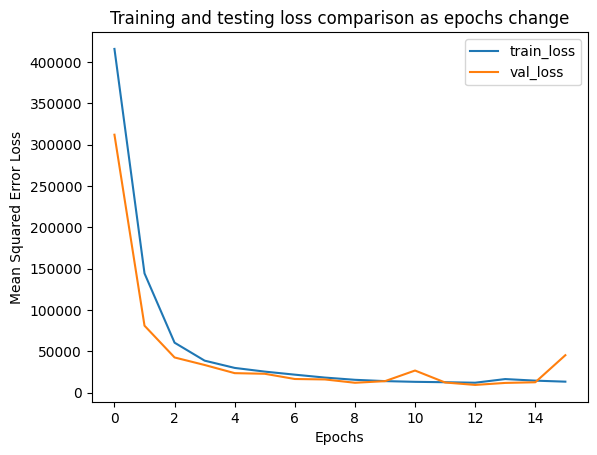

In [46]:
plt.plot(history.epoch, history.history['loss'], label='train_loss')
plt.plot(history.epoch, history.history['val_loss'], label='val_loss')
plt.title("Training and testing loss comparison as epochs change")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error Loss")
plt.legend()
plt.savefig("Plots/ann_train_val_loss.png")

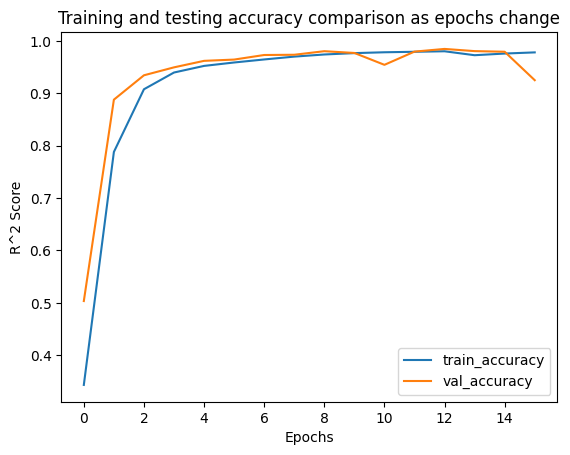

In [47]:
plt.plot(history.epoch, history.history['r_squared'], label='train_accuracy')
plt.plot(history.epoch, history.history['val_r_squared'], label='val_accuracy')
plt.title("Training and testing accuracy comparison as epochs change")
plt.xlabel("Epochs")
plt.ylabel("R^2 Score")
plt.legend()
plt.savefig("Plots/ann_train_val_acc.png")

In [48]:
y_pred = model_nn.predict(X_test)
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f%%' % (r2_score(y_test, y_pred) * 100))

2017/2017 [==============================] - 2s 983us/step
Mean squared error: 46170.28
Coefficient of determination (R^2): 93.73%
